In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import signal
import glob
import os
import copy
import hera_sim as hs
from scipy import stats




from pyuvdata import UVData, UVBeam, utils as uvutils
import hera_pspec as hp
import hera_cal as hc
import healpy

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)
path='/home/ntsikelelo/non_redundancy_sim/'

/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, 

## Load required metadata

In [2]:
model = hc.io.HERAData('/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Model_first_order_visibilities_2h_boosted_low.uvh5')
antpos, ants = model.get_ENU_antpos(pick_data_ants=True)
antpos_d = dict(zip(ants, antpos))
N=0
times = np.unique(model.time_array)
lsts = np.rad2deg(np.unwrap(model.lsts))* (24/360) # convert lsts to hours
dof=11073.0
freqs=model.freq_array[0]/1e6

## Chi-square analysis 0.25 mHz filter 

In [4]:
chisq_zeroth_red=np.load(path+"redcal_chisq_zeroth_vis_no_filter_low_2h.npy")
chisq_first_order_red=np.load(path+"redcal_chisq_first_order_vis_no_filter_low_2h.npy")

chisq_first_order_f_25_red=np.load(path+"redcal_chisq_first_order_vis_dpss_25_low_2h.npy")
chisq_first_order_f_40_red=np.load(path+"redcal_chisq_first_order_vis_no_filter_high_2h.npy")
chisq_first_order_f_60_red=np.load(path+"redcal_chisq_first_order_vis_dpss_60_low_2h_30_m.npy")


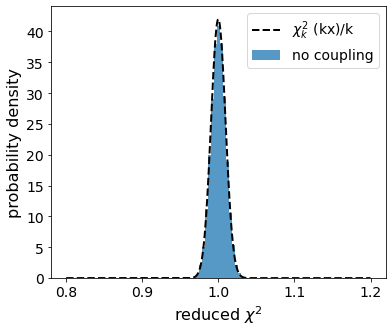

In [5]:
plt.figure(figsize=(6, 5))
plt.hist(np.abs(chisq_zeroth_red.ravel()), bins=101, range=(0.8, 1.2), density=True, alpha=0.75,label="no coupling")
x = np.linspace(0.8, 1.2, 1000)
plt.plot(x, stats.chi2.pdf(x * 2*dof, 2*dof) * 2*dof, c='k', ls='--', lw=2,label="$\chi_k^2$ (kx)/k ")
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

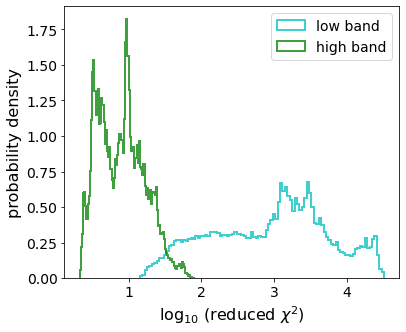

In [6]:
plt.figure(figsize=(6, 5))
plt.hist(np.log10(np.abs(chisq_first_order_red.ravel())), bins=101, density=True, alpha=0.75, label="low band",histtype='step',lw=2,color='c')
plt.hist(np.log10(np.abs(chisq_first_order_f_40_red.ravel())), bins=101, density=True, alpha=0.75, label="high band",histtype='step',lw=2,color='g')
plt.xlabel(r'$\log_{10}$ (reduced $\chi^2$)', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

In [7]:
np.mean(chisq_first_order_red.ravel()),np.mean(chisq_first_order_f_40_red.ravel())

(3266.887720890763, 10.584900814581488)

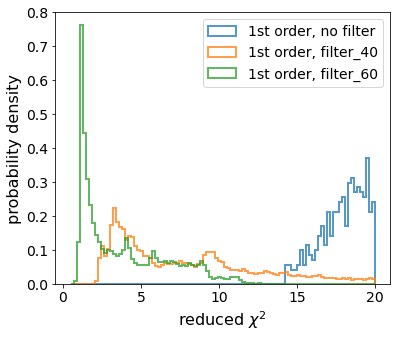

In [8]:
plt.figure(figsize=(6, 5))
plt.hist(np.abs(chisq_first_order_red.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, no filter",histtype='step',lw=2)
#plt.hist(np.abs(chisq_first_order_f_25.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, filter_25",histtype='step',lw=2)
plt.hist(np.abs(chisq_first_order_f_40_red.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, filter_40",histtype='step',lw=2)
plt.hist(np.abs(chisq_first_order_f_60_red.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, filter_60",histtype='step',lw=2)
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

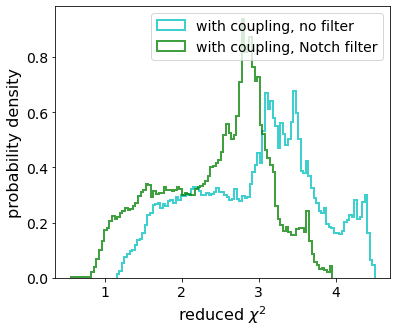

In [9]:
plt.figure(figsize=(6, 5))
plt.hist(np.log10(np.abs(chisq_first_order_red.ravel())), bins=101, density=True, alpha=0.75, label="with coupling, no filter",histtype='step',lw=2,color='c')
plt.hist(np.log10(np.abs(chisq_first_order_f_25_red.ravel())), bins=101, density=True, alpha=0.75, label="with coupling, Notch filter",histtype='step',lw=2,color='g')
# plt.hist(np.abs(chisq_first_order_f_40.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, filter_40",histtype='step',lw=2)
# plt.hist(np.abs(chisq_first_order_f_60.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, filter_60",histtype='step',lw=2)
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

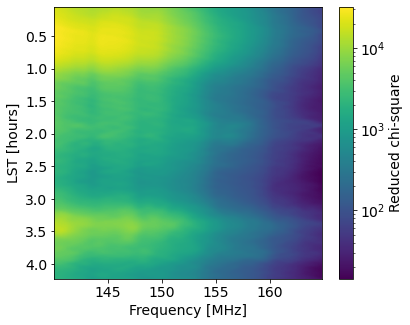

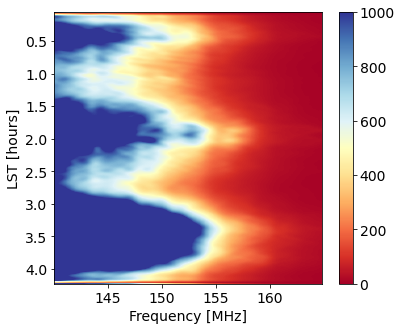

In [10]:
import matplotlib.colors as colors
plt.figure(figsize=(6, 5))
plt.imshow(chisq_first_order_red, norm=colors.LogNorm(vmin=chisq_first_order_red.min(), vmax=chisq_first_order_red.max()), cmap=plt.cm.viridis,extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]], aspect='auto')
plt.colorbar(label="Reduced chi-square")
plt.ylabel('LST [hours]')
plt.xlabel('Frequency [MHz]')

plt.show()

plt.figure(figsize=(6, 5))
plt.imshow((chisq_first_order_f_25_red), cmap=plt.cm.RdYlBu, vmin=0, vmax=1000,extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]], aspect='auto')
plt.colorbar()
plt.ylabel('LST [hours]')
plt.xlabel('Frequency [MHz]')
plt.show()



## abscal chisq

In [11]:
chisq_zeroth=np.load(path+"abscal_chisq_zeroth_vis_no_filter_low_2h.npy")
chisq_first_order=np.load(path+"abscal_chisq_first_order_vis_no_filter_low_2h.npy")

chisq_first_order_f_25=np.load(path+"abscal_chisq_zeroth_vis_dpss_25_low_2h.npy")
chisq_first_order_f_40=np.load(path+"abscal_chisq_first_order_vis_no_filter_high_2h.npy")
chisq_first_order_f_60=np.load(path+"abscal_chisq_zeroth_vis_dpss_60_low_2h.npy")

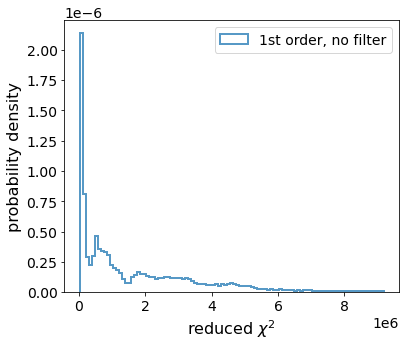

In [12]:
plt.figure(figsize=(6, 5))
plt.hist(np.abs(chisq_first_order.ravel()), bins=101, density=True, alpha=0.75, label="1st order, no filter",histtype='step',lw=2)

plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

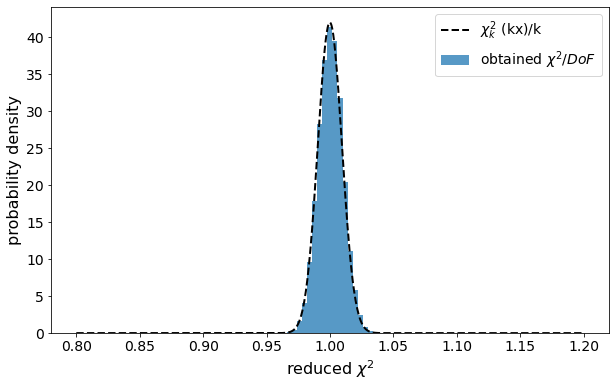

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(np.abs(chisq_zeroth.ravel()), bins=101, range=(0.8, 1.2), density=True, alpha=0.75,label="obtained $\chi^2/DoF$")
x = np.linspace(0.8, 1.2, 1000)
plt.plot(x, stats.chi2.pdf(x * 2*dof, 2*dof) * 2*dof, c='k', ls='--', lw=2,label="$\chi_k^2$ (kx)/k ")
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

Text(0, 0.5, 'probability density')

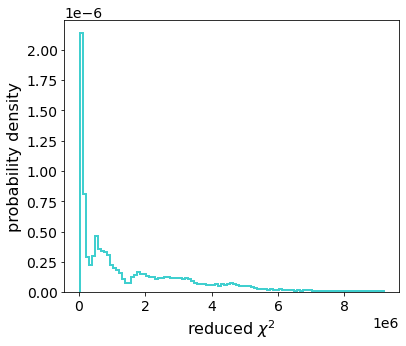

In [14]:
plt.figure(figsize=(6, 5))
plt.hist(np.abs(chisq_first_order.ravel()), bins=101, density=True, alpha=0.75, label="low band",histtype='step',lw=2,color='c')
#plt.hist(np.abs(chisq_first_order_f_40.ravel()), bins=101, range=(0.5, 1000), density=True, alpha=0.75, label="high band",histtype='step',lw=2,color='g')
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
# plt.legend()

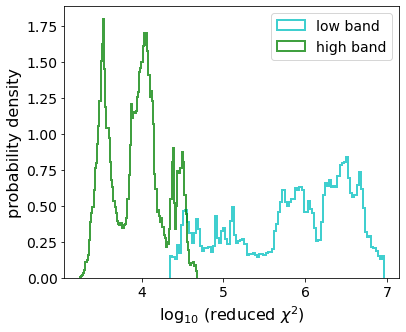

In [15]:
plt.figure(figsize=(6, 5))
plt.hist(np.log10(np.abs(chisq_first_order.ravel())), bins=101, density=True, alpha=0.75, label="low band",histtype='step',lw=2,color='c')
plt.hist(np.log10(np.abs(chisq_first_order_f_40.ravel())), bins=101, density=True, alpha=0.75, label="high band",histtype='step',lw=2,color='g')

plt.xlabel(r'$\log_{10}$ (reduced $\chi^2$)', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

In [16]:
np.mean(chisq_first_order.ravel())*1e-6,np.mean(chisq_first_order_f_40.ravel())*1e-4

(1.6931955029462677, 1.1408226167624649)

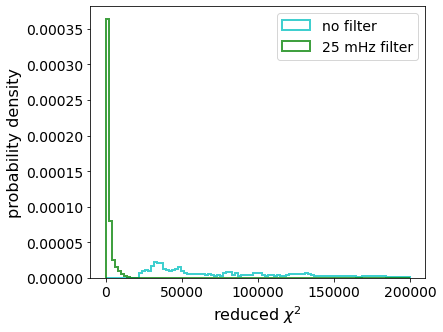

In [17]:
plt.figure(figsize=(6, 5))
plt.hist(np.abs(chisq_first_order.ravel()), bins=101,range=(0.5, 2e5), density=True, alpha=0.75, label="no filter",histtype='step',lw=2,color='c')
#plt.hist(np.abs(chisq_first_order_f_40.ravel()), bins=101, range=(0.5, 30), density=True, alpha=0.75, label="1st order, filter_40",histtype='step',lw=2)
plt.hist(np.abs(chisq_first_order_f_25.ravel()), bins=101, range=(0.5, 2e5), density=True, alpha=0.75, label="25 mHz filter",histtype='step',lw=2,color='g')
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

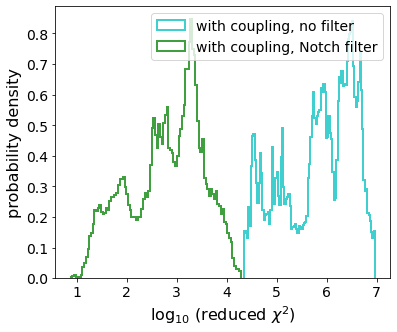

In [18]:
plt.figure(figsize=(6, 5))
plt.hist(np.log10(np.abs(chisq_first_order.ravel())), bins=101, density=True, alpha=0.75, label="with coupling, no filter",histtype='step',lw=2,color='c')
plt.hist(np.log10(np.abs(chisq_first_order_f_25.ravel())), bins=101, density=True, alpha=0.75, label="with coupling, Notch filter",histtype='step',lw=2,color='g')

plt.xlabel(r'$\log_{10}$ (reduced $\chi^2$)', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

In [19]:
np.mean(chisq_first_order_f_25.ravel())*1e-3

1.765315185064369

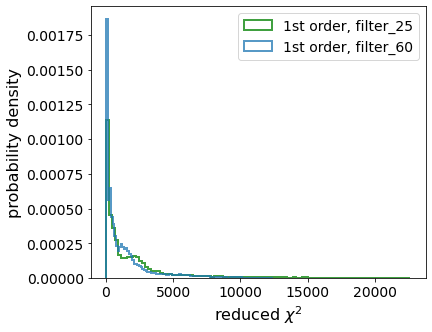

In [20]:
plt.figure(figsize=(6, 5))
#plt.hist(np.abs(chisq_first_order.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, no filter",histtype='step',lw=2,color='c')
plt.hist(np.abs(chisq_first_order_f_25.ravel()/0.85), bins=101, density=True, alpha=0.75, label="1st order, filter_25",histtype='step',lw=2,color='g')
# plt.hist(np.abs(chisq_first_order_f_40.ravel()), bins=101, range=(0.5, 20), density=True, alpha=0.75, label="1st order, filter_40",histtype='step',lw=2)
plt.hist(np.abs(chisq_first_order_f_60.ravel()), bins=101, density=True, alpha=0.75, label="1st order, filter_60",histtype='step',lw=2)
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

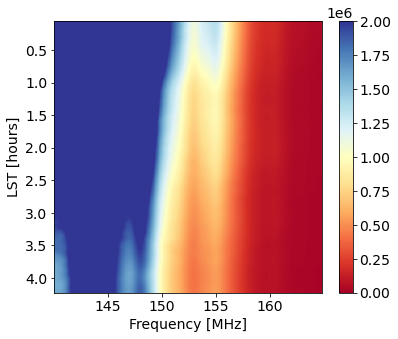

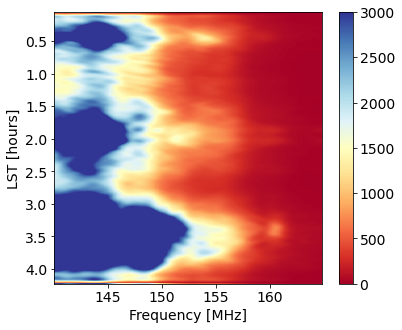

In [21]:
plt.figure(figsize=(6, 5))
plt.imshow(chisq_first_order, cmap=plt.cm.RdYlBu, vmin=0, vmax=2000000,extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]], aspect='auto')
plt.colorbar()
plt.ylabel('LST [hours]')
plt.xlabel('Frequency [MHz]')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(chisq_first_order_f_25, cmap=plt.cm.RdYlBu, vmin=0, vmax=3000,extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]], aspect='auto')
plt.colorbar()
plt.ylabel('LST [hours]')
plt.xlabel('Frequency [MHz]')
plt.show()

## Main lobe filter fixed 

In [22]:
n=np.array(np.where((0<lsts) & (lsts<1)))[0,0]
N=np.array(np.where((0<lsts) & (lsts<1)))[0,-1]

g5=np.load(path+"lincal_gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,:]
g0=np.load(path+"lincal_gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,:]
g1=np.load(path+"lincal_gains_first_order_vis_Gaussian_low_2h_0_2mHz_30_m.npy")[:,n:N,:]
g2=np.load(path+"lincal_gains_first_order_vis_dpss_25_low_2h.npy")[:,n:N,:]
g3=np.load(path+"lincal_gains_first_order_vis_Gaussian_low_2h_0_05mHz_30_m.npy")[:,n:N,:]
g4=np.load(path+"lincal_gains_first_order_vis_Gaussian_low_2h.npy")[:,n:N,:]

In [23]:
Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g2_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
g3_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 1700.0)

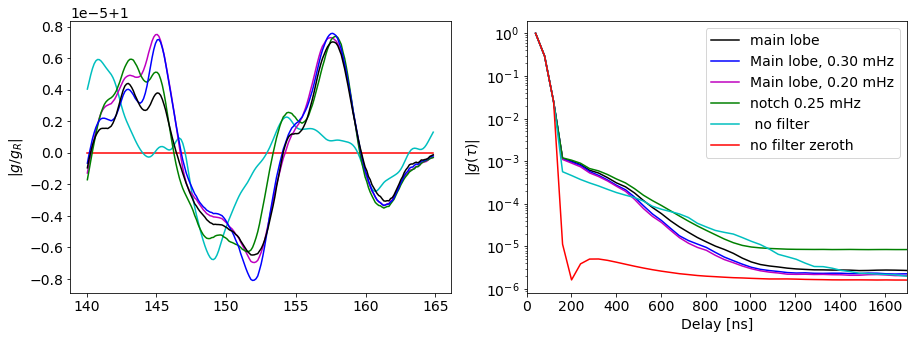

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'m',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g2/g0),axis=0), axis=0),'g',label="1 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g0),axis=0), axis=0),'b',label="2 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$|g/g_R|$")

ax=axes[1]
ax.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
ax.semilogy(tau_pos,g3_delay/np.max(g3_delay),'b',label="Main lobe, 0.30 mHz")
ax.semilogy(tau_pos,g1_delay/np.max(g1_delay),'m',label="Main lobe, 0.20 mHz")
ax.semilogy(tau_pos,g2_delay/np.max(g2_delay),'g',label="notch 0.25 mHz")
ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" no filter")
ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="no filter zeroth")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,1700)

In [25]:


g5=np.load(path+"gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,:]
g0=np.load(path+"gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,:]
g1=np.load(path+"gains_first_order_vis_Gaussian_low_2h_0_2mHz_30_m.npy")[:,n:N,:]
g2=np.load(path+"gains_first_order_vis_dpss_25_low_2h.npy")[:,n:N,:]
g3=np.load(path+"gains_first_order_vis_Gaussian_low_2h_0_05mHz_30_m.npy")[:,n:N,:]
g4=np.load(path+"gains_first_order_vis_Gaussian_low_2h.npy")[:,n:N,:]

In [26]:

tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g2_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
g3_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 1700.0)

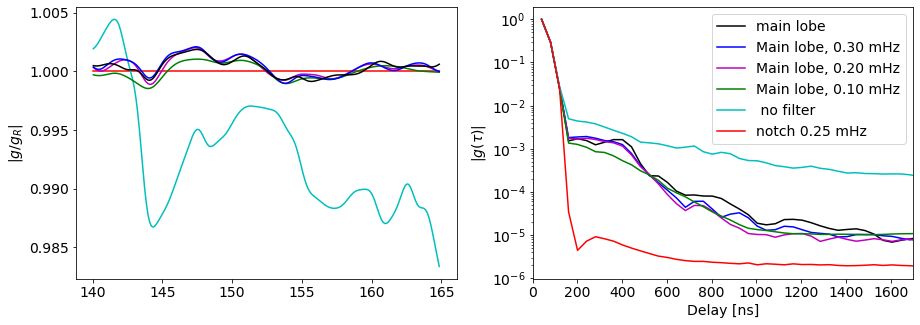

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'m',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g2/g0),axis=0), axis=0),'g',label="1 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g0),axis=0), axis=0),'b',label="2 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$|g/g_R|$")




ax=axes[1]
ax.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
ax.semilogy(tau_pos,g3_delay/np.max(g3_delay),'b',label="Main lobe, 0.30 mHz")
ax.semilogy(tau_pos,g1_delay/np.max(g1_delay),'m',label="Main lobe, 0.20 mHz")
ax.semilogy(tau_pos,g2_delay/np.max(g2_delay),'g',label="Main lobe, 0.10 mHz")
ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" no filter")
ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="notch 0.25 mHz")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,1700)

## Baseline cut test

In [28]:
freqs=model.freq_array[0]/1e6
n=np.array(np.where((0<lsts) & (lsts<1)))[0,0]
N=np.array(np.where((0<lsts) & (lsts<1)))[0,-1]

g5=np.load(path+"gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,:]
g0=np.load(path+"gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,:]
g1=np.load(path+"gains_first_order_vis_Gaussian_low_2h_0_2mHz_30_m.npy")[:,n:N,:]
g2=np.load(path+"gains_first_order_vis_Gaussian_low_2h_0_2mHz_40_m.npy")[:,n:N,:]
g3=np.load(path+"gains_first_order_vis_Gaussian_low_2h_0_2mHz_50_m.npy")[:,n:N,:]
g4=np.load(path+"gains_first_order_vis_dpss_25_low_2h.npy")[:,n:N,:]

Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g2_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
g3_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 1700.0)

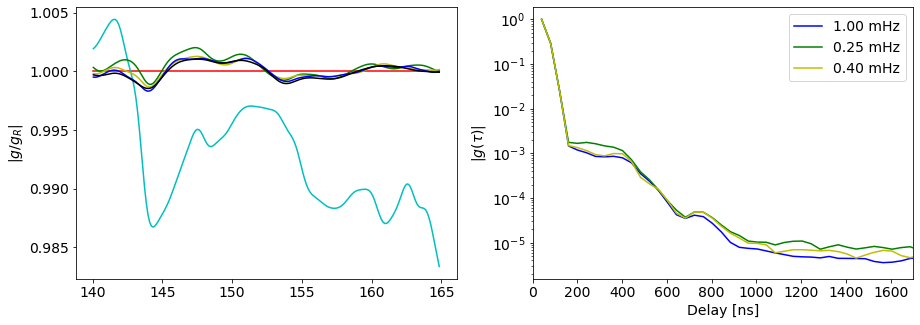

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g2/g0),axis=0), axis=0),'y',label="1 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g0),axis=0), axis=0),'b',label="2 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$|g/g_R|$")

ax=axes[1]
# ax.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
ax.semilogy(tau_pos,g3_delay/np.max(g3_delay),'b',label="1.00 mHz")
ax.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
ax.semilogy(tau_pos,g2_delay/np.max(g2_delay),'y',label="0.40 mHz")
# ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
# ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,1700)

(0.0, 1500.0)

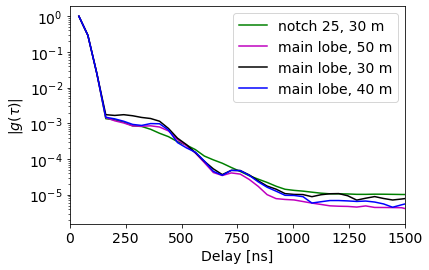

In [30]:
plt.semilogy(tau_pos,g4_delay/np.max(g4_delay),'g',label="notch 25, 30 m")
plt.semilogy(tau_pos,g3_delay/np.max(g3_delay),'m',label="main lobe, 50 m")
plt.semilogy(tau_pos,g1_delay/np.max(g1_delay),'k',label="main lobe, 30 m")
plt.semilogy(tau_pos,g2_delay/np.max(g2_delay),'b',label="main lobe, 40 m")
# ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
# ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,1500)

In [31]:

g5=np.load(path+"gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,:]
g0=np.load(path+"gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,:]
g1=np.load(path+"gains_first_order_vis_Gaussian_low_2h__30_m.npy")[:,n:N,:]
g2=np.load(path+"gains_first_order_vis_Gaussian_low_2h__50_m.npy")[:,n:N,:]
g3=np.load(path+"gains_first_order_vis_Gaussian_low_2h__100_m.npy")[:,n:N,:]
g4=np.load(path+"gains_first_order_vis_dpss_25_low_2h.npy")[:,n:N,:]

Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g2_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
g3_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 1500.0)

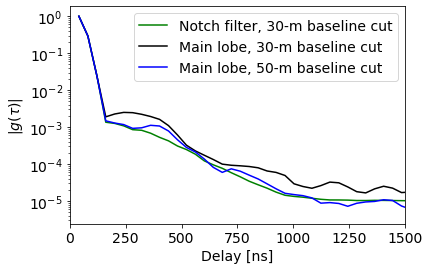

In [32]:
plt.semilogy(tau_pos,g4_delay/np.max(g4_delay),'g',label="Notch filter, 30-m baseline cut")
# plt.semilogy(tau_pos,g3_delay/np.max(g3_delay),'m',label="main lobe, 100 m")
plt.semilogy(tau_pos,g1_delay/np.max(g1_delay),'k',label="Main lobe, 30-m baseline cut")
plt.semilogy(tau_pos,g2_delay/np.max(g2_delay),'b',label="Main lobe, 50-m baseline cut")
# ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
# ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,1500)

## Gain comparison 25 and 60 mHz 

In [33]:
n=np.array(np.where((0<lsts) & (lsts<1)))[0,0]
N=np.array(np.where((0<lsts) & (lsts<1)))[0,-1]

g5=np.load(path+"gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,:]
g0=np.load(path+"gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,:]
g1=np.load(path+"gains_first_order_vis_dpss_25_low_2h.npy")[:,n:N,:]
g4=np.load(path+"gains_first_order_vis_dpss_60_low_2h.npy")[:,n:N,:]

Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g0[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 2000.0)

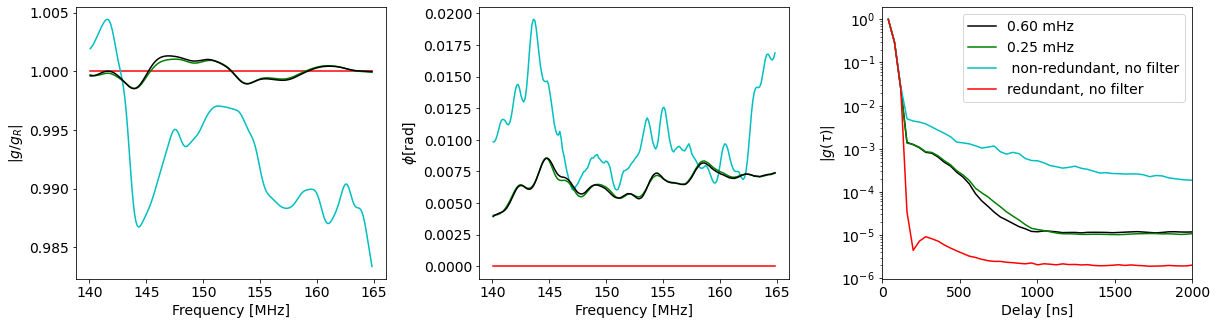

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")

ant_idx = 18
ax=axes[1]
ax.plot(freqs,np.mean(np.mean(np.angle(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.angle(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.angle(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.angle(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")

ax=axes[2]
ax.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="0.60 mHz")
ax.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,2000)


## No filter 

In [54]:
n=0
N=lsts.shape[0]
g5=np.load(path+"lincal_gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,0:203]
g0=np.load(path+"lincal_gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,0:203]
g2=np.load(path+"lincal_gains_zeroth_vis_no_filter_high_2h.npy")[:,n:N,0:203]
g3=np.load(path+"lincal_gains_first_order_vis_no_filter_high_2h.npy")[:,n:N,0:203]

In [55]:
freqs=freqs[0:203]

In [56]:
Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs[0:203]),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g0[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g2_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
g3_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]


Text(0.5, 0, 'Frequency [MHz]')

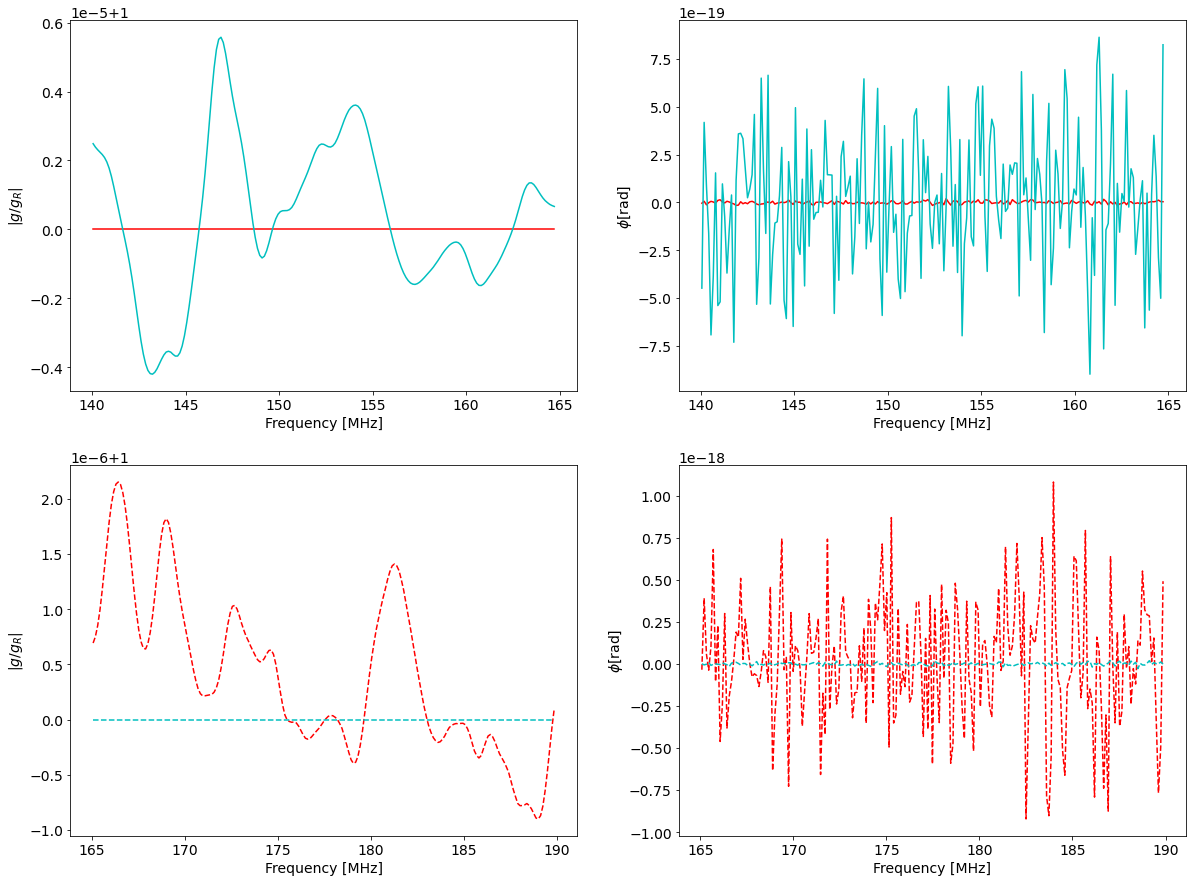

In [57]:
freqs_high=np.linspace(165.0848388671875, 189.8651123046875,203)
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.subplots_adjust(wspace=0.2)
ax=axes[0,0]
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="redundant, low band")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="non-rendunant, low band")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")
# ax.set_ylim(0.999991,1.00001)

ax=axes[0,1]
ax.plot(freqs,np.mean(np.mean(np.angle(g0/g0),axis=0), axis=0),'r',label="redundant, low band")    
ax.plot(freqs, np.mean(np.mean(np.angle(g5/g0),axis=0), axis=0),'c',label="non-rendunant, low band")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")
# ax.set_ylim(0.999991,1.00001)

ax=axes[1,0]
ax.plot(freqs_high,np.mean(np.mean(np.abs(g3/g2),axis=0), axis=0),'r--',label="redundant, l band")    
ax.plot(freqs_high, np.mean(np.mean(np.abs(g2/g2),axis=0), axis=0),'c--',label="non-rendunant, low band")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")



ax=axes[1,1]
ax.plot(freqs_high,np.mean(np.mean(np.angle(g3/g2),axis=0), axis=0),'r--',label="redundant, l band")    
ax.plot(freqs_high, np.mean(np.mean(np.angle(g2/g2),axis=0), axis=0),'c--',label="non-rendunant, low band")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")

(0.0, 2000.0)

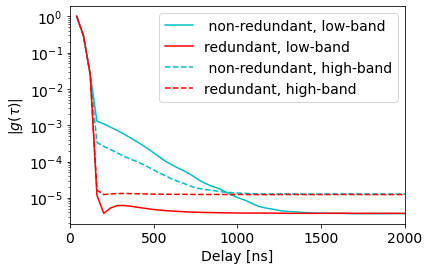

In [58]:
plt.figure()
plt.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, low-band")
plt.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, low-band")
plt.semilogy(tau_pos,g3_delay/np.max(g3_delay),'c--',label=" non-redundant, high-band")
plt.semilogy(tau_pos,g2_delay/np.max(g2_delay),'r--',label="redundant, high-band")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,2000)

In [59]:


g5=np.load(path+"gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,0:203]
g0=np.load(path+"gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,0:203]
g2=np.load(path+"gains_zeroth_vis_no_filter_high_2h.npy")[:,n:N,0:203]
g3=np.load(path+"gains_first_order_vis_no_filter_high_2h.npy")[:,n:N,0:203]


Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs[0:204]),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g0[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g2_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
g3_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]



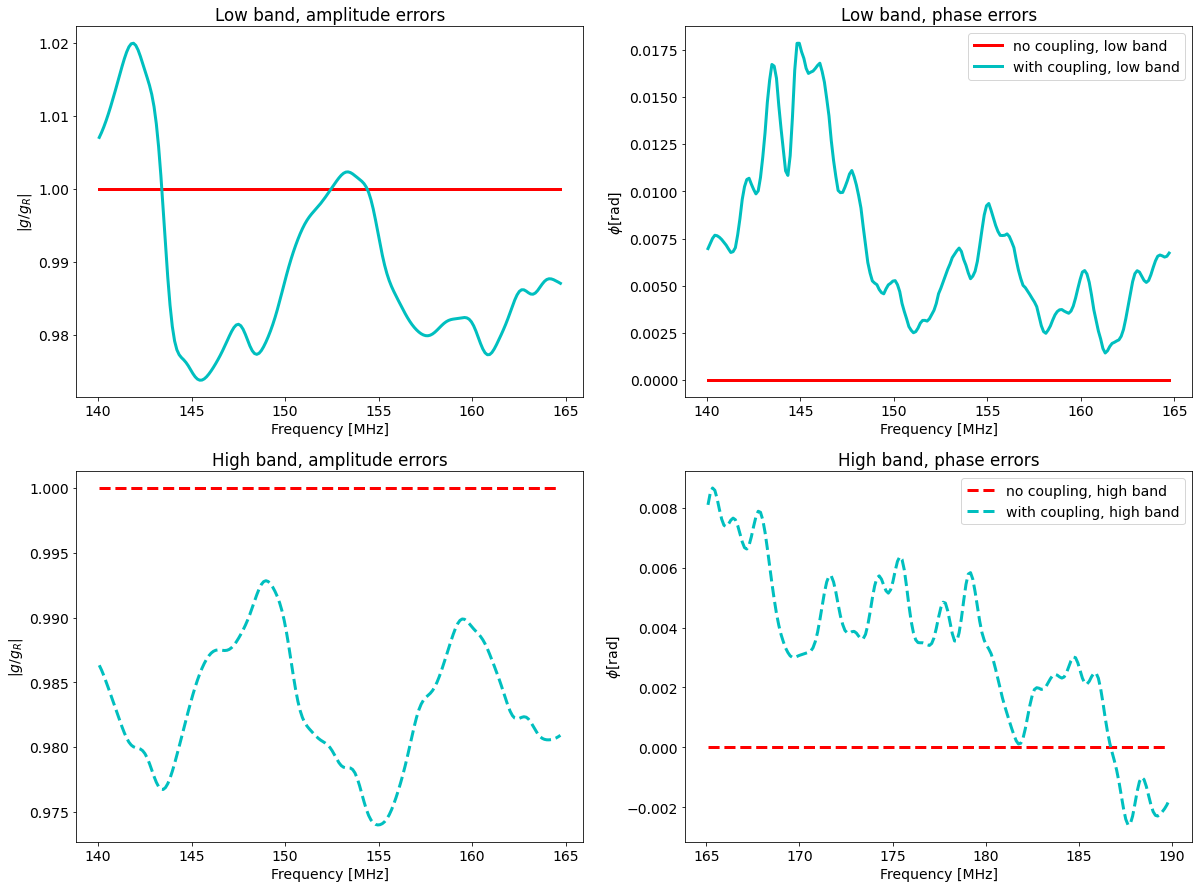

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.subplots_adjust(wspace=0.2)
ax=axes[0,0]
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',lw=3, label="redundant, low band")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',lw=3, label="non-rendunant, low band")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")
ax.set_title('Low band, amplitude errors') 
# ax.set_ylim(0.999991,1.00001)

ax=axes[0,1]
ax.plot(freqs,np.mean(np.mean(np.angle(g0/g0),axis=0), axis=0),'r',lw=3,label="no coupling, low band")    
ax.plot(freqs, np.mean(np.mean(np.angle(g5/g0),axis=0), axis=0),'c',lw=3,label="with coupling, low band")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")
ax.set_title('Low band, phase errors') 
# ax.set_ylim(0.999991,1.00001)
ax.legend()

ax=axes[1,0]
ax.plot(freqs,np.mean(np.mean(np.abs(g2/g2),axis=0), axis=0),'r--',lw=3,label="redundant, l band")    
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g2),axis=0), axis=0),'c--',lw=3,label="non-rendunant, low band")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")
ax.set_title('High band, amplitude errors')



ax=axes[1,1]
ax.plot(freqs_high,np.mean(np.mean(np.angle(g2/g2),axis=0), axis=0),'r--',lw=3,label="no coupling, high band")    
ax.plot(freqs_high, np.mean(np.mean(np.angle(g3/g2),axis=0), axis=0),'c--',lw=3,label="with coupling, high band")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")
ax.set_title('High band, phase errors')
ax.legend()







(0.0, 2000.0)

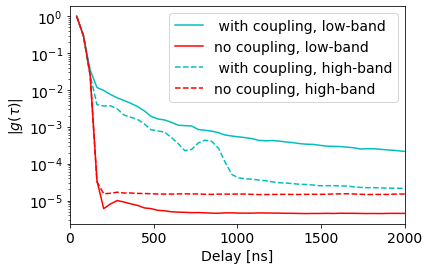

In [61]:
plt.figure()
plt.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" with coupling, low-band")
plt.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="no coupling, low-band")
plt.semilogy(tau_pos,g3_delay/np.max(g3_delay),'c--',label=" with coupling, high-band")
plt.semilogy(tau_pos,g2_delay/np.max(g2_delay),'r--',label="no coupling, high-band")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,2000)

# Gains filtered

In [62]:
freqs=model.freq_array[0]/1e6
n=np.array(np.where((0<lsts) & (lsts<1)))[0,0]
N=np.array(np.where((0<lsts) & (lsts<1)))[0,-1]

print(n,N,lsts[n],lsts[N])


0 58 0.05264093928161628 0.9893539926092955


In [63]:
g5=np.load(path+"gains_first_order_vis_no_filter_low_2h.npy")[:,n:N,:]
g0=np.load(path+"gains_zeroth_vis_no_filter_low_2h.npy")[:,n:N,:]
g1=np.load(path+"gains_first_order_vis_dpss_25_low_2h.npy")[:,n:N,:]
g4=np.load(path+"gains_first_order_vis_Gaussian_low_2h.npy")[:,n:N,:]


Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g0[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 2000.0)

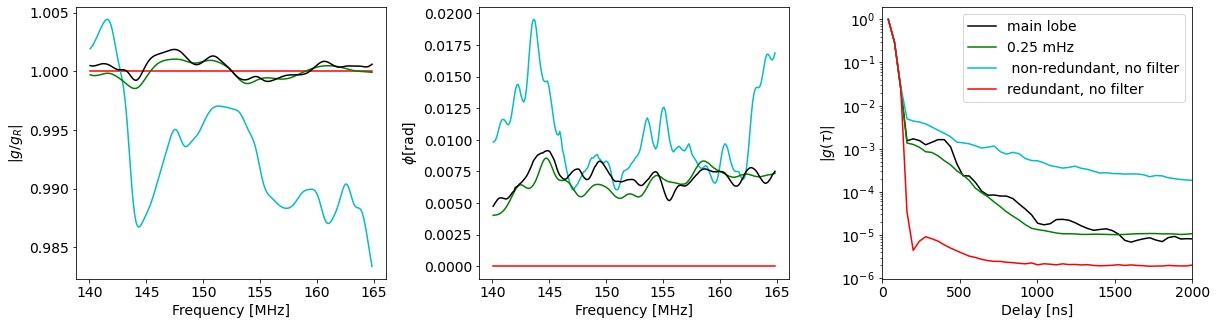

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")

ant_idx = 18
ax=axes[1]
ax.plot(freqs,np.mean(np.mean(np.angle(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.angle(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.angle(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.angle(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")

ax=axes[2]
ax.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
ax.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,2000)

(0.0, 2000.0)

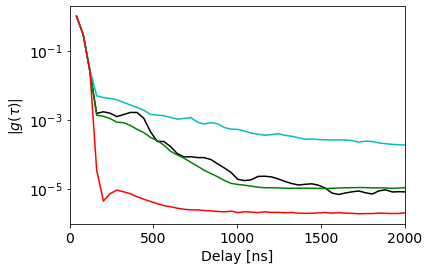

In [65]:
plt.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
plt.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
plt.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
plt.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
# plt.legend()
plt.xlim(0,2000)

(0.0, 250.0)

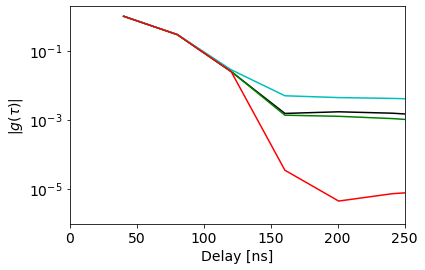

In [66]:
plt.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
plt.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
plt.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
plt.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
# plt.legend()
plt.xlim(0,250)

## High band 

In [67]:
freqs_high=np.linspace(165.0848388671875, 189.8651123046875,203)
freqs=freqs_high
g5=np.load(path+"gains_first_order_vis_no_filter_high_2h.npy")[:,n:N,:]
g0=np.load(path+"gains_zeroth_vis_no_filter_high_2h.npy")[:,n:N,:]
g1=np.load(path+"gains_first_order_vis_dpss_25_high_2h.npy")[:,n:N,:]
g4=np.load(path+"gains_first_order_vis_Gaussian_high_2h.npy")[:,n:N,:]


Nant=len(ants)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g0.shape)
for ant in range (Nant):
    for t in range (N-n):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g0[18,:,:]),axis=0)))

g0_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
g1_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
g5_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
g4_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 2000.0)

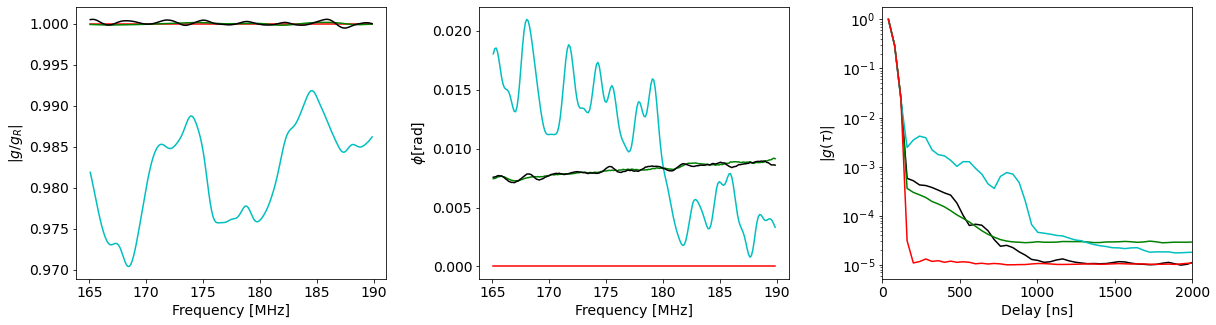

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$|g/g_R|$")
ax.set_xlabel("Frequency [MHz]")

ant_idx = 18
ax=axes[1]
ax.plot(freqs,np.mean(np.mean(np.angle(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.angle(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.angle(g1/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.angle(g4/g0),axis=0), axis=0),'k',label="main lobe")
ax.set_ylabel("$\\phi$[rad]")
ax.set_xlabel("Frequency [MHz]")

ax=axes[2]
ax.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
ax.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
ax.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
ax.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
# ax.legend()
ax.set_xlim(0,2000)

(0.0, 2000.0)

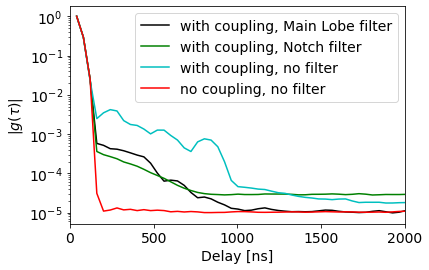

In [69]:
plt.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="with coupling, Main Lobe filter")
plt.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="with coupling, Notch filter")
plt.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label="with coupling, no filter")
plt.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="no coupling, no filter")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,2000)

(0.0, 250.0)

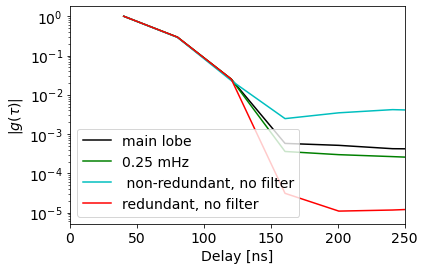

In [70]:
plt.semilogy(tau_pos,g4_delay/np.max(g4_delay),'k',label="main lobe")
plt.semilogy(tau_pos,g1_delay/np.max(g1_delay),'g',label="0.25 mHz")
plt.semilogy(tau_pos,g5_delay/np.max(g5_delay),'c',label=" non-redundant, no filter")
plt.semilogy(tau_pos,g0_delay/np.max(g0_delay),'r',label="redundant, no filter")
plt.xlabel("Delay [ns]")
plt.ylabel("$|g(\\tau)|$")
plt.legend()
plt.xlim(0,250)

In [71]:
sigma=np.load("/home/ntsikelelo/non_redundancy_sim/sigma_gaussian_low.npy",allow_pickle=True).item()
f_value=np.load("/home/ntsikelelo/non_redundancy_sim/fringe_value_gaussian_low.npy",allow_pickle=True).item()
bls_E_W=np.load("/home/ntsikelelo/non_redundancy_sim/E_W_baseline_gaussian_low.npy",allow_pickle=True).item()

In [72]:
width=[]
f=[]
blsew=[]
for k in sigma:
    width.append(sigma[k])
    f.append(-f_value[k]*1e3)
    blsew.append(bls_E_W[k])

(30.0, 60.0)

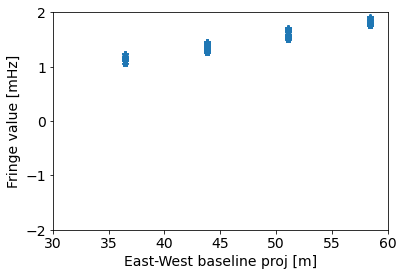

In [73]:
plt.plot(blsew,f,'*')
plt.ylabel("Fringe value [mHz]")
plt.xlabel("East-West baseline proj [m]")
plt.ylim([-2,2])
plt.xlim([30,60])

(30.0, 60.0)

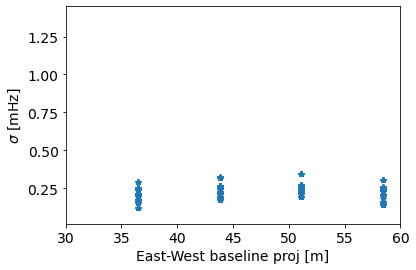

In [74]:
plt.plot(blsew,np.abs(width),'*')
plt.ylabel("$\\sigma$ [mHz]")
plt.xlabel("East-West baseline proj [m]")
plt.xlim([30,60])

(-60.0, -30.0)

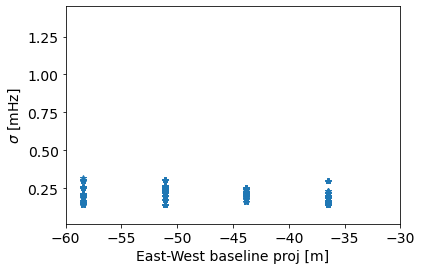

In [75]:
plt.plot(blsew,np.abs(width),'*')
plt.ylabel("$\\sigma$ [mHz]")
plt.xlabel("East-West baseline proj [m]")
plt.xlim([-60,-30])

Text(0.5, 0, 'East-West baseline proj [m]')

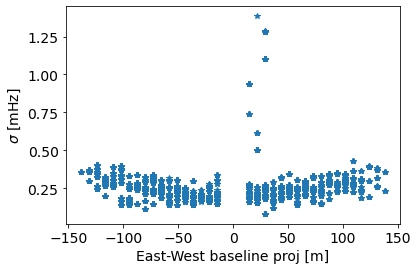

In [76]:
plt.plot(blsew,np.abs(width),'*')
plt.ylabel("$\\sigma$ [mHz]")
plt.xlabel("East-West baseline proj [m]")
# plt.xlim([-60,60])